In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

In [5]:
# -----------------------------------------------------------------------------------------------------------------------------
# Data_preprocessing - Function to preprocess the data:
# Function to download data files if they do not exist


def download_data(urls, path, filenames):
    """
    Downloads data files from given URLs if they do not
    already exist at the specified path.
    """
    # Ensure the directory exists
    if not os.path.exists(path):
        print(f"Creating Folder {path}")
        os.makedirs(path)
    else:
        print(f"Folder {path} found")

    for url, filename in zip(urls, filenames):
        # Combine path and filename
        file_path = os.path.join(path, filename)

        if not os.path.exists(file_path):
            print(f"Downloading {filename} from {url}...")
            try:
                # Send a GET request and follow redirects
                # (default behavior of requests)
                response = requests.get(url, allow_redirects=True)

                if response.status_code == 200:
                    with open(file_path, 'wb') as f:
                        f.write(response.content)
                    print(f"Downloaded {filename} to {file_path}")
                else:
                    print(f"Failed to download {filename} - HTTP \
                            Status Code: {response.status_code}")

            except requests.exceptions.RequestException as e:
                print(f"An error occurred while downloading {filename}: {e}")

        else:
            print(f"File already present: {file_path}")

# -----------------------------------------------------------------------------------------------------------------------------
# Function to load data from npz files


def load_data(path, filenames):
    """
    Loads data from multiple .npz files in the specified directory (`path`)
    and combines them into a single numpy array.
    """
    alldat = []

    for filename in filenames:
        # Combine path with filename
        file_path = os.path.join(path, filename)
        print(f"Loading data to RAM from: {filename}")
        data = np.load(file_path, allow_pickle=True)['dat']

        # Append data to the list
        alldat.append(data)

    # Convert list to numpy array and combine
    return np.hstack(alldat)


In [6]:
# Import my import functions and also change working directory to access them
path_to_project = "/media/mdempg/SSD_Space/Projects/NMA_IS_2024/"

print(f"Init work directory: {os.getcwd()}")
os.chdir(path_to_project)
print(f"New work directory: {os.getcwd()}")

# ------------------------------------------------------------------------------
# URLs to download the "10 ms bin" data if not already present
urls = ["https://osf.io/agvxh/download", "https://osf.io/uv3mw/download", "https://osf.io/ehmw2/download"]

# ------------------------------------------------------------------------------
# Filenames corresponding to the URLs
filenames = ['steinmetz_part0.npz', 'steinmetz_part1.npz', 'steinmetz_part2.npz']
path = "/media/mdempg/SSD_Space/Projects/NMA_IS_2024/data/processed"

# ------------------------------------------------------------------------------
# Download data if not already present
download_data(urls, path, filenames)

# ------------------------------------------------------------------------------
# Load all data from files -> (This takes 30s):
#"""
alldat = load_data(path, filenames)
#"""
# ------------------------------------------------------------------------------

Init work directory: /media/mdempg/SSD_Space/Projects/NMA_IS_2024/notebooks
New work directory: /media/mdempg/SSD_Space/Projects/NMA_IS_2024
Folder /media/mdempg/SSD_Space/Projects/NMA_IS_2024/data/processed found
File already present: /media/mdempg/SSD_Space/Projects/NMA_IS_2024/data/processed/steinmetz_part0.npz
File already present: /media/mdempg/SSD_Space/Projects/NMA_IS_2024/data/processed/steinmetz_part1.npz
File already present: /media/mdempg/SSD_Space/Projects/NMA_IS_2024/data/processed/steinmetz_part2.npz
Loading data to RAM from: steinmetz_part0.npz
Loading data to RAM from: steinmetz_part1.npz
Loading data to RAM from: steinmetz_part2.npz


In [7]:
# Funcion to get Neuron indexes for specific Brain Areas
def Get_Neurons_from_brain_region(alldat, Session_i, region_name):

    dat_session = alldat[Session_i]
    NeuronIDs_from_regions = []

    for region_name_subgroup in region_name:
        # Get the indices where the 'brain_area' matches the region_name_subgroup
        matching_indices = np.where(dat_session['brain_area'] == region_name_subgroup)[0]

        # Convert the indices to a list
        matching_indices_list = matching_indices.tolist()

        NeuronIDs_from_regions += matching_indices_list

    NeuronIDs_from_regions.sort()
    return NeuronIDs_from_regions

In [8]:
def calculate_trial_filtered_PSTH_with_no_normalization(alldat, Neuron_IDs_for_set_session_Brain_region, trial_mask_enum):

    # "Selected Session", "Selected Neurons", "Selected Trials", "Time bins"

    # trial_mask_enum = 0 : Left Correct and Right Correct
    # trial_mask_enum = 1 : Left Correct L=1 R=0.5      and Right Correct R=1 L=0.5
    # trial_mask_enum = 2 : Left Correct L=1 R=0.25     and Right Correct R=1 L=0.25
    # trial_mask_enum = 3 : Left Correct L=1 R=0        and Right Correct R=1 L=0
    # trial_mask_enum = 4 : Left Correct L=0.5 R=0.25   and Right Correct R=0.5 L=0.25
    # trial_mask_enum = 5 : Left Correct L=0.5 R=0      and Right Correct R=0.5 L=0
    # trial_mask_enum = 6 : Left Correct L=0.25 R=0     and Right Correct R=0.25 L=0

    length = len(alldat[0]['spks'][0, 0, :])

    PSTH_spike_sum_timebin_LC_allsessions = np.full(length, 0)
    PSTH_timebin_sum_timebin_LC_allsessions = np.full(length, 0)
    PSTH_spike_sum_timebin_RC_allsessions = np.full(length, 0)
    PSTH_timebin_sum_timebin_RC_allsessions = np.full(length, 0)

    for sessions in range(len(Neuron_IDs_for_set_session_Brain_region)):
        session_ID = Neuron_IDs_for_set_session_Brain_region[sessions][0]
        Neuron_IDs = Neuron_IDs_for_set_session_Brain_region[sessions][1]
        dat_session = alldat[session_ID]

        # Create Masks for Trials for a Session:
        feedback_correct_mask       = (dat_session['feedback_type'] ==  1) # correct trials + some random reward and no-go trials
        if trial_mask_enum == 0:
            contrast_left_bigger_mask   = (dat_session['contrast_left'] > dat_session['contrast_right'])
            contrast_right_bigger_mask  = (dat_session['contrast_left'] < dat_session['contrast_right'])
        if trial_mask_enum == 1:
            mask_A = (dat_session['contrast_left'] == 1); mask_B = (dat_session['contrast_right'] == 0.5)
            mask_C = (dat_session['contrast_left'] == 0.5); mask_D = (dat_session['contrast_right'] == 1)
            contrast_left_bigger_mask   = mask_A & mask_B
            contrast_right_bigger_mask  = mask_C & mask_D
        if trial_mask_enum == 2:
            mask_A = (dat_session['contrast_left'] == 1); mask_B = (dat_session['contrast_right'] == 0.25)
            mask_C = (dat_session['contrast_left'] == 0.25); mask_D = (dat_session['contrast_right'] == 1)
            contrast_left_bigger_mask   = mask_A & mask_B
            contrast_right_bigger_mask  = mask_C & mask_D
        if trial_mask_enum == 3:
            mask_A = (dat_session['contrast_left'] == 1); mask_B = (dat_session['contrast_right'] == 0)
            mask_C = (dat_session['contrast_left'] == 0); mask_D = (dat_session['contrast_right'] == 1)
            contrast_left_bigger_mask   = mask_A & mask_B
            contrast_right_bigger_mask  = mask_C & mask_D
        if trial_mask_enum == 4:
            mask_A = (dat_session['contrast_left'] == 0.5); mask_B = (dat_session['contrast_right'] == 0.25)
            mask_C = (dat_session['contrast_left'] == 0.25); mask_D = (dat_session['contrast_right'] == 0.5)
            contrast_left_bigger_mask   = mask_A & mask_B
            contrast_right_bigger_mask  = mask_C & mask_D
        if trial_mask_enum == 5:
            mask_A = (dat_session['contrast_left'] == 0.5); mask_B = (dat_session['contrast_right'] == 0)
            mask_C = (dat_session['contrast_left'] == 0); mask_D = (dat_session['contrast_right'] == 0.5)
            contrast_left_bigger_mask   = mask_A & mask_B
            contrast_right_bigger_mask  = mask_C & mask_D
        if trial_mask_enum == 6:
            mask_A = (dat_session['contrast_left'] == 0.25); mask_B = (dat_session['contrast_right'] == 0)
            mask_C = (dat_session['contrast_left'] == 0); mask_D = (dat_session['contrast_right'] == 0.25)
            contrast_left_bigger_mask   = mask_A & mask_B
            contrast_right_bigger_mask  = mask_C & mask_D

        Left_Correct_trial_mask     = contrast_left_bigger_mask & feedback_correct_mask
        Right_Correct_trial_mask    = contrast_right_bigger_mask & feedback_correct_mask

        dat_session_spks = dat_session['spks']

        amount_of_nuerons = len(Neuron_IDs)
        count_trials_pre_session = len(dat_session_spks[0, :, 0])
        count_time_bins_pre_trial = len(dat_session_spks[0, 0, :])

        # The length of the temporary trial,
        # the bins that aggrigate the sums with time offsets possible
        # in the possitive and negative direction
        # zero time is linked to the begining of the first trial

        length = count_time_bins_pre_trial

        # Left Correct
        PSTH_spike_sum_timebin_LC = np.full(length, 0) 
        PSTH_timebin_sum_timebin_LC = np.full(length, 0) 
        
        # Right Correct
        PSTH_spike_sum_timebin_RC = np.full(length, 0)
        PSTH_timebin_sum_timebin_RC = np.full(length, 0)

        print(f"session_ID: {session_ID}")

        for neurons in range(amount_of_nuerons):

            for trials in range(count_trials_pre_session):
                
                if (Left_Correct_trial_mask[trials] == True) or Right_Correct_trial_mask[trials] == True:

                    for time_bins in range(count_time_bins_pre_trial):

                        spks_neuron_trial_time_bins = dat_session_spks[Neuron_IDs[neurons], trials, time_bins]
                                                 
                        if (Left_Correct_trial_mask[trials] == True):
                            PSTH_spike_sum_timebin_LC[time_bins] += spks_neuron_trial_time_bins
                            PSTH_timebin_sum_timebin_LC[time_bins] += 1                

                        if (Right_Correct_trial_mask[trials] == True):
                            PSTH_spike_sum_timebin_RC[time_bins] += spks_neuron_trial_time_bins
                            PSTH_timebin_sum_timebin_RC[time_bins] += 1

        PSTH_spike_sum_timebin_LC_allsessions += PSTH_spike_sum_timebin_LC
        PSTH_timebin_sum_timebin_LC_allsessions += PSTH_timebin_sum_timebin_LC
        PSTH_spike_sum_timebin_RC_allsessions += PSTH_spike_sum_timebin_RC
        PSTH_timebin_sum_timebin_RC_allsessions += PSTH_timebin_sum_timebin_RC

    PSTH_LC = PSTH_spike_sum_timebin_LC_allsessions / PSTH_timebin_sum_timebin_LC_allsessions
    PSTH_RC = PSTH_spike_sum_timebin_RC_allsessions / PSTH_timebin_sum_timebin_RC_allsessions

    return PSTH_LC, PSTH_RC

In [9]:
def normalize_PSTH_with_padding(PSTH):

    ratio = PSTH / np.mean(PSTH)

    return ratio


In [10]:
# Short list of Sessions for VISp and CA1:
Session_ids_VISp = [0, 2, 3, 7, 9, 11, 13, 19, 21, 24, 25, 38]
Session_ids_CA1 = [1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 18, 19, 22, 23, 26, 27, 29, 32, 34, 38]

Neuron_ids = []
region_name_1 = ["VISp"]
region_name_2 = ["CA1"]

Neuron_IDs_for_set_session_VISp = []
Neuron_IDs_for_set_session_CA1 = []

# Get Neurons in VISp and CA1 for each Session that have them:
for Session_id in Session_ids_VISp:

    temp_neurons_ids = Get_Neurons_from_brain_region(alldat, Session_id, region_name_1)
    Neuron_IDs_for_set_session_VISp.append((Session_id, temp_neurons_ids))

for Session_id in Session_ids_CA1:
    
    temp_neurons_ids = Get_Neurons_from_brain_region(alldat, Session_id, region_name_2)
    Neuron_IDs_for_set_session_CA1.append((Session_id, temp_neurons_ids))

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

PSTH_LC_VISp_cases = []
PSTH_RC_VISp_cases = []
PSTH_LC_CA1_cases = []
PSTH_RC_CA1_cases = []

for case_id in range(7):
    print(f"case_id: {case_id}")

    PSTH_LC_VISp, PSTH_RC_VISp = calculate_trial_filtered_PSTH_with_no_normalization(alldat, Neuron_IDs_for_set_session_VISp, case_id)
    # Normalize and append:
    PSTH_LC_VISp_cases.append(normalize_PSTH_with_padding(PSTH_LC_VISp))
    PSTH_RC_VISp_cases.append(normalize_PSTH_with_padding(PSTH_RC_VISp))

    PSTH_LC_CA1, PSTH_RC_CA1 = calculate_trial_filtered_PSTH_with_no_normalization(alldat, Neuron_IDs_for_set_session_CA1, case_id)
    # Normalize and append:
    PSTH_LC_CA1_cases.append(normalize_PSTH_with_padding(PSTH_LC_CA1))
    PSTH_RC_CA1_cases.append(normalize_PSTH_with_padding(PSTH_RC_CA1))

case_id: 0
session_ID: 0
session_ID: 2
session_ID: 3
session_ID: 7
session_ID: 9
session_ID: 11
session_ID: 13
session_ID: 19
session_ID: 21
session_ID: 24
session_ID: 25
session_ID: 38
session_ID: 1
session_ID: 2
session_ID: 3
session_ID: 4
session_ID: 5
session_ID: 7
session_ID: 8
session_ID: 9
session_ID: 11
session_ID: 12
session_ID: 13
session_ID: 18
session_ID: 19
session_ID: 22
session_ID: 23
session_ID: 26
session_ID: 27
session_ID: 29
session_ID: 32
session_ID: 34
session_ID: 38
case_id: 1
session_ID: 0
session_ID: 2
session_ID: 3
session_ID: 7
session_ID: 9
session_ID: 11
session_ID: 13
session_ID: 19
session_ID: 21
session_ID: 24
session_ID: 25
session_ID: 38
session_ID: 1
session_ID: 2
session_ID: 3
session_ID: 4
session_ID: 5
session_ID: 7
session_ID: 8
session_ID: 9
session_ID: 11
session_ID: 12
session_ID: 13
session_ID: 18
session_ID: 19
session_ID: 22
session_ID: 23
session_ID: 26
session_ID: 27
session_ID: 29
session_ID: 32
session_ID: 34
session_ID: 38
case_id: 2
ses

/tmp/ipykernel_321/395655972.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', 12)


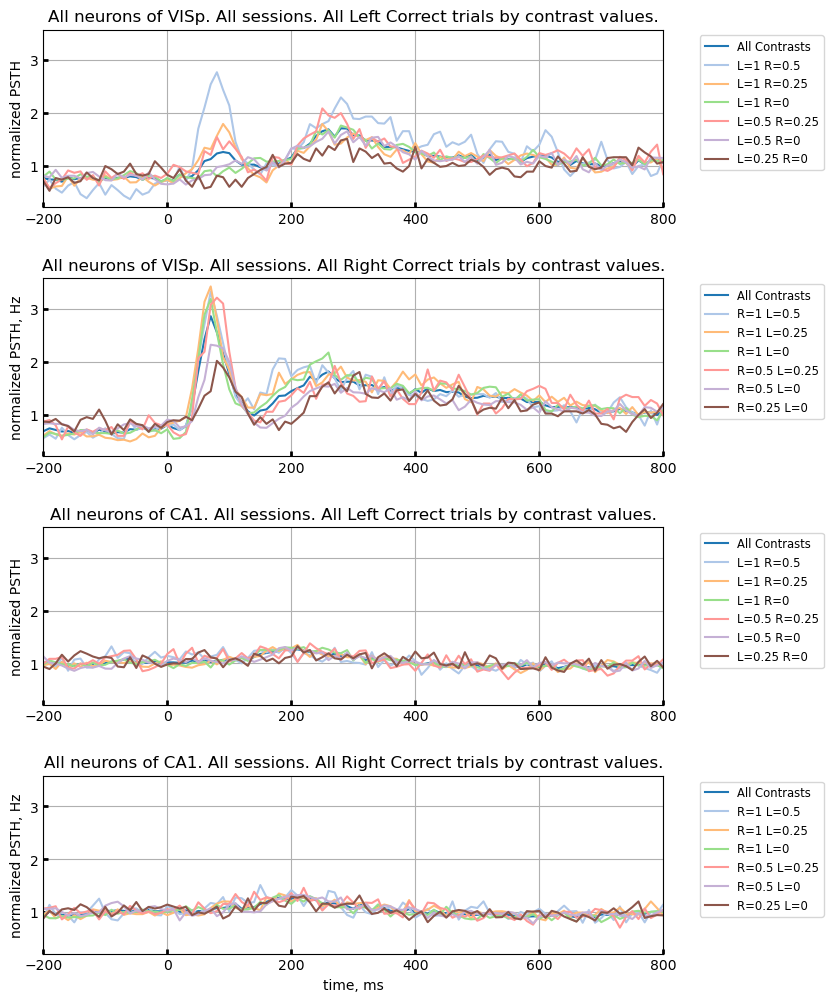

In [11]:

# Create a figure and axis with 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(4, 1, figsize=(8, 12), sharey=True)  # 1 row, 2 columns

length = len(alldat[0]['spks'][0, 0, :])
# Define the x-axis values explicitly (starting from zero)
x_values = np.arange(0, length)*10-500

# trial_mask_enum = 0 : Left Correct and Right Correct
# trial_mask_enum = 1 : Left Correct L=1 R=0.5      and Right Correct R=1 L=0.5
# trial_mask_enum = 2 : Left Correct L=1 R=0.25     and Right Correct R=1 L=0.25
# trial_mask_enum = 3 : Left Correct L=1 R=0        and Right Correct R=1 L=0
# trial_mask_enum = 4 : Left Correct L=0.5 R=0.25   and Right Correct R=0.5 L=0.25
# trial_mask_enum = 5 : Left Correct L=0.5 R=0      and Right Correct R=0.5 L=0
# trial_mask_enum = 6 : Left Correct L=0.25 R=0     and Right Correct R=0.25 L=0

# Create a list of labels and colors if you want to assign them dynamically
labels_VISp_LC  = ['All Contrasts', 'L=1 R=0.5', 'L=1 R=0.25', 'L=1 R=0', 'L=0.5 R=0.25', 'L=0.5 R=0', 'L=0.25 R=0']
labels_VISp_RC  = ['All Contrasts', 'R=1 L=0.5', 'R=1 L=0.25', 'R=1 L=0', 'R=0.5 L=0.25', 'R=0.5 L=0', 'R=0.25 L=0']
labels_CA1_LC   = ['All Contrasts', 'L=1 R=0.5', 'L=1 R=0.25', 'L=1 R=0', 'L=0.5 R=0.25', 'L=0.5 R=0', 'L=0.25 R=0']
labels_CA1_RC   = ['All Contrasts', 'R=1 L=0.5', 'R=1 L=0.25', 'R=1 L=0', 'R=0.5 L=0.25', 'R=0.5 L=0', 'R=0.25 L=0']

# Generate a colormap with as many colors as there are data arrays
cmap = cm.get_cmap('tab20', 12)

# Initialize a counter for colors
color_index = 0

# Plot each array dynamically
for i, data in enumerate(PSTH_LC_VISp_cases):
    axes[0].plot(x_values, PSTH_LC_VISp_cases[i], label=labels_VISp_LC[i], color=cmap(color_index))
    color_index += 1


color_index = 0
for i, data in enumerate(PSTH_RC_VISp_cases):
    axes[1].plot(x_values, PSTH_RC_VISp_cases[i], label=labels_VISp_RC[i], color=cmap(color_index))
    color_index += 1


color_index = 0
for i, data in enumerate(PSTH_LC_CA1_cases):
    axes[2].plot(x_values, PSTH_LC_CA1_cases[i], label=labels_CA1_LC[i], color=cmap(color_index))
    color_index += 1


color_index = 0
for i, data in enumerate(PSTH_RC_CA1_cases):
    axes[3].plot(x_values, PSTH_RC_CA1_cases[i], label=labels_CA1_RC[i], color=cmap(color_index))
    color_index += 1


# Add labels and title (optional)
axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[2].set_xlabel('')
axes[3].set_xlabel('time, ms')

axes[0].set_ylabel('normalized PSTH')
axes[1].set_ylabel('normalized PSTH, Hz')
axes[2].set_ylabel('normalized PSTH')
axes[3].set_ylabel('normalized PSTH, Hz')

axes[0].set_title('All neurons of VISp. All sessions. All Left Correct trials by contrast values.')
axes[1].set_title('All neurons of VISp. All sessions. All Right Correct trials by contrast values.')
axes[2].set_title('All neurons of CA1. All sessions. All Left Correct trials by contrast values.')
axes[3].set_title('All neurons of CA1. All sessions. All Right Correct trials by contrast values.')

# Add the legend to the plot with smaller font size and place it outside the plot
axes[0].legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')  # Placing legend on the right side
axes[1].legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')  # Placing legend on the right side
axes[2].legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')  # Placing legend on the right side
axes[3].legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')  # Placing legend on the right side

# Display the plot
axes[0].grid(True)
axes[1].grid(True)
axes[2].grid(True)
axes[3].grid(True)

'''
y_min = 0
y_max = 150
axes[0].set_ylim(y_min, y_max)
axes[1].set_ylim(y_min, y_max)
axes[2].set_ylim(y_min, y_max)
axes[3].set_ylim(y_min, y_max)
'''

x_min = -200
x_max = 800
axes[0].set_xlim(x_min, x_max)
axes[1].set_xlim(x_min, x_max)
axes[2].set_xlim(x_min, x_max)
axes[3].set_xlim(x_min, x_max)

# Make ticks bold and inside the plot
for ax in axes:
    ax.tick_params(axis='both', which='major', direction='in', labelsize=10, width=2)

    # Set bold tick labels
    #ax.set_xticklabels(ax.get_xticks(), fontweight='bold')
    #ax.set_yticklabels(ax.get_yticks(), fontweight='bold')

# Adjust space between subplots
plt.subplots_adjust(hspace=0.4)  # Increase the space between subplots

plt.show()

/tmp/ipykernel_321/3212731306.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', 12)


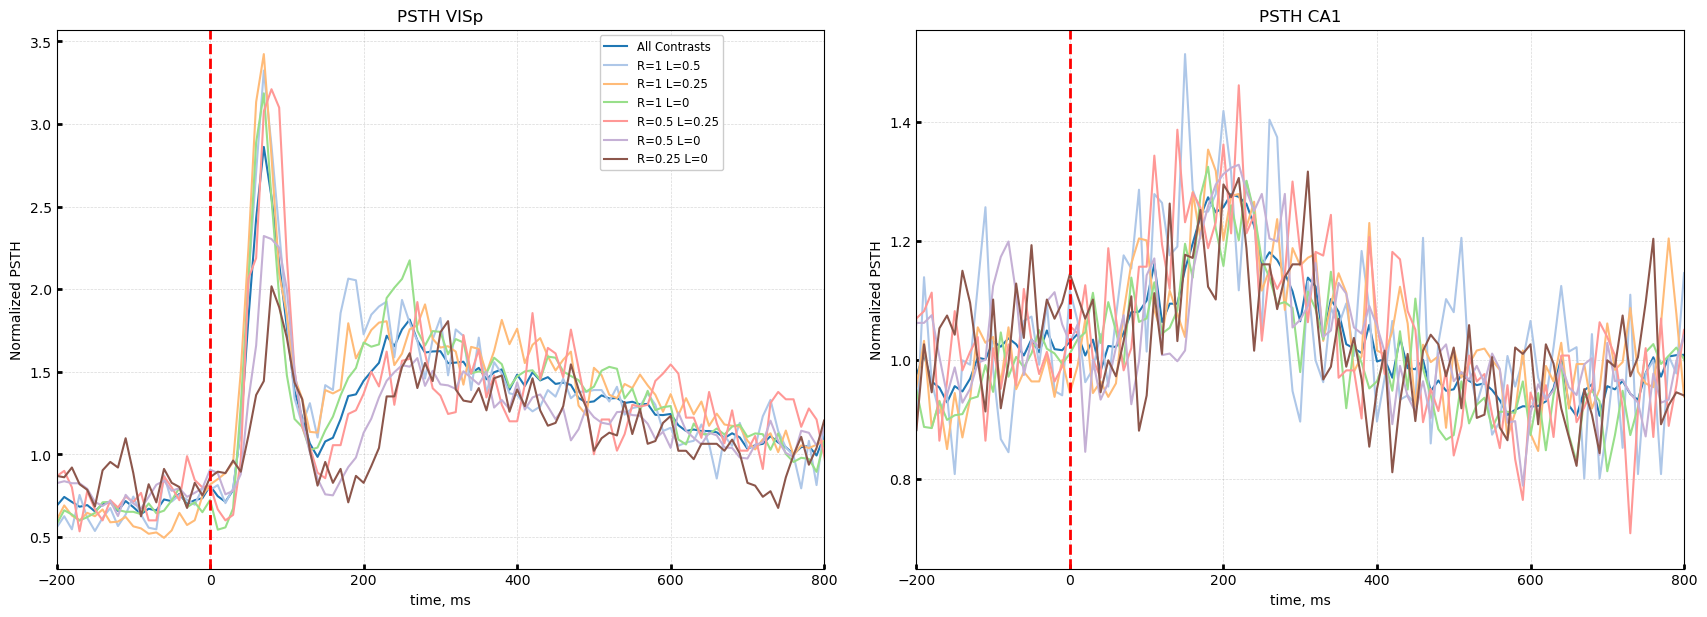

In [15]:
# Create a figure and axis with 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(21, 7))  # 1 row, 2 columns # sharey=True

length = len(alldat[0]['spks'][0, 0, :])
# Define the x-axis values explicitly (starting from zero)
x_values = np.arange(0, length)*10-500

# trial_mask_enum = 1 : Left Correct L=1 R=0.5      and Right Correct R=1 L=0.5
# trial_mask_enum = 2 : Left Correct L=1 R=0.25     and Right Correct R=1 L=0.25
# trial_mask_enum = 3 : Left Correct L=1 R=0        and Right Correct R=1 L=0
# trial_mask_enum = 4 : Left Correct L=0.5 R=0.25   and Right Correct R=0.5 L=0.25
# trial_mask_enum = 5 : Left Correct L=0.5 R=0      and Right Correct R=0.5 L=0
# trial_mask_enum = 6 : Left Correct L=0.25 R=0     and Right Correct R=0.25 L=0

# Create a list of labels and colors if you want to assign them dynamically
labels_VISp_RC  = ['All Contrasts', 'R=1 L=0.5', 'R=1 L=0.25', 'R=1 L=0', 'R=0.5 L=0.25', 'R=0.5 L=0', 'R=0.25 L=0']
labels_CA1_RC   = ['All Contrasts', 'R=1 L=0.5', 'R=1 L=0.25', 'R=1 L=0', 'R=0.5 L=0.25', 'R=0.5 L=0', 'R=0.25 L=0']

# Generate a colormap with as many colors as there are data arrays
cmap = cm.get_cmap('tab20', 12)

# Initialize a counter for colors

color_index = 0
for i, data in enumerate(PSTH_RC_VISp_cases):
    axes[0].plot(x_values, PSTH_RC_VISp_cases[i], label=labels_VISp_RC[i], color=cmap(color_index))
    color_index += 1

color_index = 0
for i, data in enumerate(PSTH_RC_CA1_cases):
    axes[1].plot(x_values, PSTH_RC_CA1_cases[i], label=labels_CA1_RC[i], color=cmap(color_index))
    color_index += 1


# Add labels and title (optional)
axes[0].set_xlabel('time, ms')
axes[1].set_xlabel('time, ms')

axes[0].set_ylabel('Normalized PSTH')
axes[1].set_ylabel('Normalized PSTH')

axes[0].set_title('PSTH VISp')
axes[1].set_title('PSTH CA1')

# Add the legend to the plot with smaller font size and place it outside the plot
axes[1].legend(fontsize='small', bbox_to_anchor=(-0.42, 1), loc='upper left', framealpha=1)  # Placing legend on the right side
#axes[1].legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')  # Placing legend on the right side

# Display the plot
axes[0].grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
axes[1].grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

#y_min = 0
#y_max = 8
#axes[0].set_ylim(y_min, y_max)
#axes[1].set_ylim(y_min, y_max)

x_min = -200
x_max = 800
axes[0].set_xlim(x_min, x_max)
axes[1].set_xlim(x_min, x_max)

# Make ticks bold and inside the plot
for ax in axes:
    ax.tick_params(axis='both', which='major', direction='in', labelsize=10, width=2)

    # Set bold tick labels
    #ax.set_xticklabels(ax.get_xticks(), fontweight='bold')
    #ax.set_yticklabels(ax.get_yticks(), fontweight='bold')

# Adjust space between subplots
plt.subplots_adjust(wspace=0.12)  # Increase the space between subplots

axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)  # Vertical red line
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)  # Vertical red line

plt.show()